# Car Classification Model Training

This notebook trains a Hybrid ResNet-ViT model for Indonesian car classification using the collected dataset. The model combines ResNet-50 as a feature extractor with a Vision Transformer for classification.

## Dataset Structure
- **Classes**: 8 Indonesian car types (hatchback, mpv, offroad, pickup, sedan, suv, truck, van)
- **Architecture**: Hybrid ResNet-ViT combining CNN and Transformer
- **Training Strategy**: Transfer learning with data augmentation
- **Class Imbalance**: Handled using weighted loss function for better minority class performance

## Training Process
1. Dataset exploration and class imbalance analysis
2. Model training with weighted loss and comprehensive tracking
3. Performance analysis with detailed charts and metrics
4. Model evaluation with per-class analysis and confusion matrix
5. Training insights and recommendations for optimization

In [1]:
!rm -rf /kaggle/working
!git clone https://github.com/luthfiarifin/Hybrid-RViT-Car-Retrieval.git code
!mv code/* .
!ls

rm: cannot remove '/kaggle/working': Device or resource busy
Cloning into 'code'...
remote: Enumerating objects: 34236, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 34236 (delta 8), reused 3 (delta 3), pack-reused 34220 (from 4)
Receiving objects: 100% (34236/34236), 998.79 MiB | 47.23 MiB/s, done.
Resolving deltas: 100% (322/322), done.
Updating files: 100% (25031/25031), done.
1_run_scraper_into_dataset.ipynb	code		 models
2_train_the_classification_model.ipynb	data_processing


In [2]:
# Import required libraries
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import os
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")

# Set style for plots
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(
        f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB"
    )

Libraries imported successfully!
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla P100-PCIE-16GB
CUDA memory: 15.9 GB


2025-06-23 04:05:40.875497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750651541.075171      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750651541.133573      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===
Using device: cuda
Logging to TensorBoard: logs/train_classification/run_1750651556


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


Using weighted CrossEntropyLoss with weights: tensor([0.9608, 1.7266, 0.6568, 1.4423, 0.7932, 0.5169, 3.2113, 1.5216],
       device='cuda:0')

📊 Class Distribution Analysis:
Class        Count    Percentage Imbalance Ratio
--------------------------------------------------
city_car     1240     13.0      % 1.86           x
hatchback    690      7.2       % 3.34           x
mpv          1814     19.0      % 1.27           x
pickup       826      8.7       % 2.79           x
sedan        1502     15.8      % 1.53           x
suv          2305     24.2      % 1.00           x
truck        371      3.9       % 6.21           x
van          783      8.2       % 2.94           x

📈 Imbalance Factor: 6.21x (Most frequent / Least frequent)
⚠️  High imbalance detected! Consider using weighted loss or resampling.
Trainer initialized successfully!
Training samples: 9531
Validation samples: 1191
Number of batches per epoch: 149
Class names: ['city_car', 'hatchback', 'mpv', 'pickup', 'sedan', 'suv

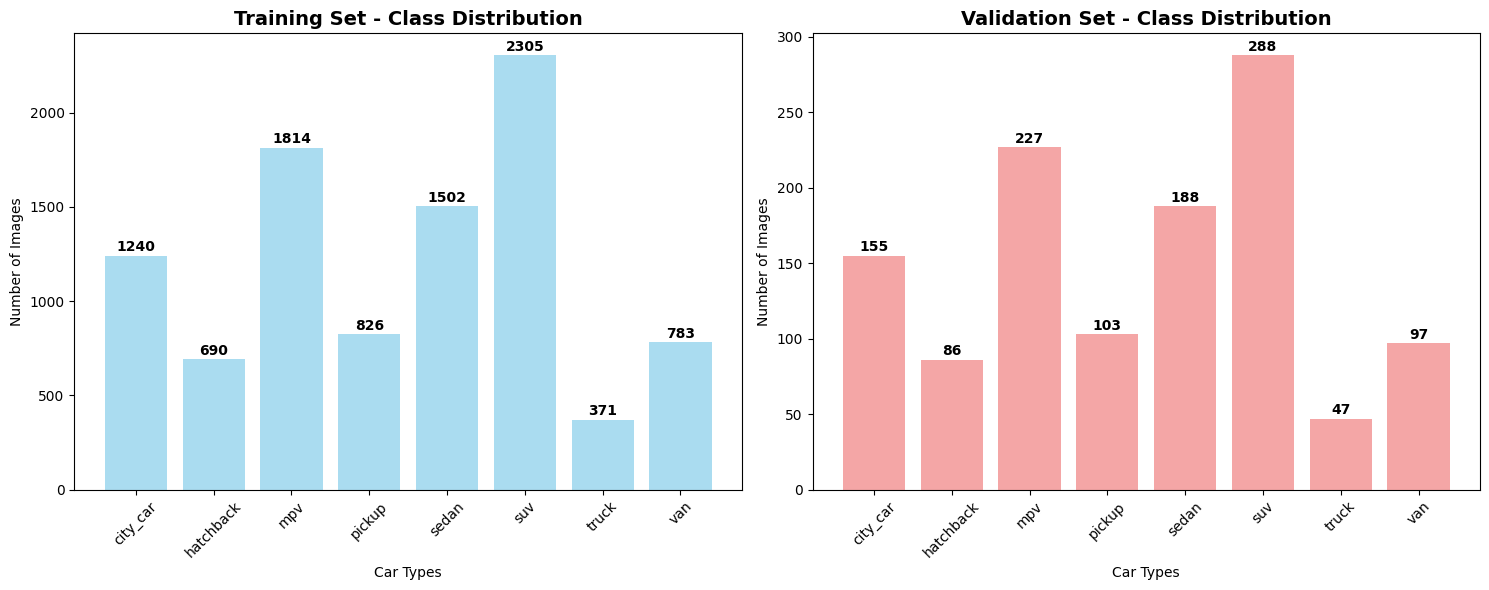


=== Dataset Summary ===
    Class  Training  Validation  Total  Train_Ratio
 city_car      1240         155   1395        0.889
hatchback       690          86    776        0.889
      mpv      1814         227   2041        0.889
   pickup       826         103    929        0.889
    sedan      1502         188   1690        0.889
      suv      2305         288   2593        0.889
    truck       371          47    418        0.888
      van       783          97    880        0.890


In [3]:
# Training configuration

from models.classification.train_classification import CarClassifierTrainer

CONFIG = {
    "train_dir": "data_processing/data/dataset/train",
    "val_dir": "data_processing/data/dataset/val",
    "num_classes": 8,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 6,
    "dropout": 0.1,
    "learning_rate": 1e-4,
    "batch_size": 64,
    "num_epochs": 25,
    "result_path": f'models/results/carvit_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}.pth',
    "use_weighted_loss": True,
    "use_class_balancing": False,
    "num_workers": 8,
    "early_stopping_patience": 7,
    "early_stopping_delta": 0.001,
    "early_stopping_verbose": True,
}

# Initialize the trainer with class imbalance handling and early stopping
print("\n=== Initializing Trainer with Class Imbalance Handling & Early Stopping ===")
trainer = CarClassifierTrainer(
    train_dir=CONFIG["train_dir"],
    val_dir=CONFIG["val_dir"],
    num_classes=CONFIG["num_classes"],
    embed_dim=CONFIG["embed_dim"],
    num_heads=CONFIG["num_heads"],
    num_layers=CONFIG["num_layers"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    batch_size=CONFIG["batch_size"],
    num_epochs=CONFIG["num_epochs"],
    result_path=CONFIG["result_path"],
    use_weighted_loss=CONFIG["use_weighted_loss"],
    use_class_balancing=CONFIG["use_class_balancing"],
    num_workers=CONFIG["num_workers"],
    early_stopping_patience=CONFIG["early_stopping_patience"],
    early_stopping_delta=CONFIG["early_stopping_delta"],
    early_stopping_verbose=CONFIG["early_stopping_verbose"],
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(trainer.train_dataset)}")
print(f"Validation samples: {len(trainer.val_dataset)}")
print(f"Number of batches per epoch: {len(trainer.train_loader)}")
print(f"Class names: {trainer.train_dataset.classes}")

from models.classification.training_report import TrainingReport

# Create a training report instance
report = TrainingReport(trainer, CONFIG, None)

# Generate and summary report
report.dataset_summary_report()

In [4]:
# Start training with detailed tracking
start_time = time.time()

# Execute training
training_results = trainer.train()

# Print training results
total_time = time.time() - start_time
print(f"\n=== Training Completed in {total_time:.2f} seconds ===")

Starting training with detailed tracking and early stopping...
Early Stopping - Patience: 7, Delta: 0.001
Model parameters: 143,116,360
Trainable parameters: 143,116,360

Epoch 1/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=1.38] 


Validation accuracy: 65.49%
Validation loss: 0.8841
Time: 101.77s | LR: 1.00e-04
🎉 New best accuracy: 65.49%
Validation loss decreased (inf --> 0.884120).  Saving model ...

Epoch 2/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.932]


Validation accuracy: 75.15%
Validation loss: 0.6795
Time: 101.79s | LR: 1.00e-04
🎉 New best accuracy: 75.15%
Validation loss decreased (0.884120 --> 0.679517).  Saving model ...

Epoch 3/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.412]


Validation accuracy: 78.09%
Validation loss: 0.6198
Time: 101.49s | LR: 1.00e-04
🎉 New best accuracy: 78.09%
Validation loss decreased (0.679517 --> 0.619828).  Saving model ...

Epoch 4/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.408]


Validation accuracy: 78.25%
Validation loss: 0.6383
Time: 101.78s | LR: 1.00e-04
🎉 New best accuracy: 78.25%
EarlyStopping counter: 1 out of 7

Epoch 5/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.253]


Validation accuracy: 83.71%
Validation loss: 0.5520
Time: 101.54s | LR: 1.00e-04
🎉 New best accuracy: 83.71%
Validation loss decreased (0.619828 --> 0.551984).  Saving model ...

Epoch 6/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.423]


Validation accuracy: 84.72%
Validation loss: 0.5243
Time: 101.21s | LR: 1.00e-04
🎉 New best accuracy: 84.72%
Validation loss decreased (0.551984 --> 0.524335).  Saving model ...

Epoch 7/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.377]


Validation accuracy: 86.06%
Validation loss: 0.5392
Time: 102.00s | LR: 1.00e-04
🎉 New best accuracy: 86.06%
EarlyStopping counter: 1 out of 7

Epoch 8/25


100%|██████████| 149/149 [01:37<00:00,  1.53it/s, loss=0.18] 


Validation accuracy: 86.15%
Validation loss: 0.5369
Time: 102.19s | LR: 1.00e-04
🎉 New best accuracy: 86.15%
EarlyStopping counter: 2 out of 7

Epoch 9/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.207] 


Validation accuracy: 86.23%
Validation loss: 0.5792
Time: 102.00s | LR: 1.00e-04
🎉 New best accuracy: 86.23%
EarlyStopping counter: 3 out of 7

Epoch 10/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.158] 


Validation accuracy: 85.81%
Validation loss: 0.5377
Time: 101.86s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 11/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.0966]


Validation accuracy: 85.89%
Validation loss: 0.5760
Time: 101.71s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 12/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.294] 


Validation accuracy: 86.23%
Validation loss: 0.5977
Time: 101.89s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 13/25


100%|██████████| 149/149 [01:35<00:00,  1.55it/s, loss=0.226] 


Validation accuracy: 87.66%
Validation loss: 0.4722
Time: 100.98s | LR: 1.00e-04
🎉 New best accuracy: 87.66%
Validation loss decreased (0.524335 --> 0.472221).  Saving model ...

Epoch 14/25


100%|██████████| 149/149 [01:35<00:00,  1.55it/s, loss=0.175] 


Validation accuracy: 86.99%
Validation loss: 0.5056
Time: 100.90s | LR: 1.00e-04
EarlyStopping counter: 1 out of 7

Epoch 15/25


100%|██████████| 149/149 [01:36<00:00,  1.54it/s, loss=0.139] 


Validation accuracy: 87.57%
Validation loss: 0.5554
Time: 102.05s | LR: 1.00e-04
EarlyStopping counter: 2 out of 7

Epoch 16/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.117] 


Validation accuracy: 87.07%
Validation loss: 0.5176
Time: 101.59s | LR: 1.00e-04
EarlyStopping counter: 3 out of 7

Epoch 17/25


100%|██████████| 149/149 [01:35<00:00,  1.55it/s, loss=0.04]  


Validation accuracy: 87.15%
Validation loss: 0.5203
Time: 100.91s | LR: 1.00e-04
EarlyStopping counter: 4 out of 7

Epoch 18/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.153] 


Validation accuracy: 87.57%
Validation loss: 0.5524
Time: 101.45s | LR: 1.00e-04
EarlyStopping counter: 5 out of 7

Epoch 19/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.197] 


Validation accuracy: 87.24%
Validation loss: 0.5532
Time: 101.52s | LR: 1.00e-04
EarlyStopping counter: 6 out of 7

Epoch 20/25


100%|██████████| 149/149 [01:36<00:00,  1.55it/s, loss=0.0662]


Validation accuracy: 86.99%
Validation loss: 0.5537
Time: 101.46s | LR: 1.00e-04
EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered at epoch 20
Best validation loss: 0.472221

Training completed!
Training stopped early at epoch 20 due to no improvement in validation loss
Best validation accuracy: 87.66%
Loading best model with validation loss: 0.472221
Best accuracy model saved to models/results/carvit_model_20250623_040556_best_acc.pth

=== Training Completed in 2041.88 seconds ===


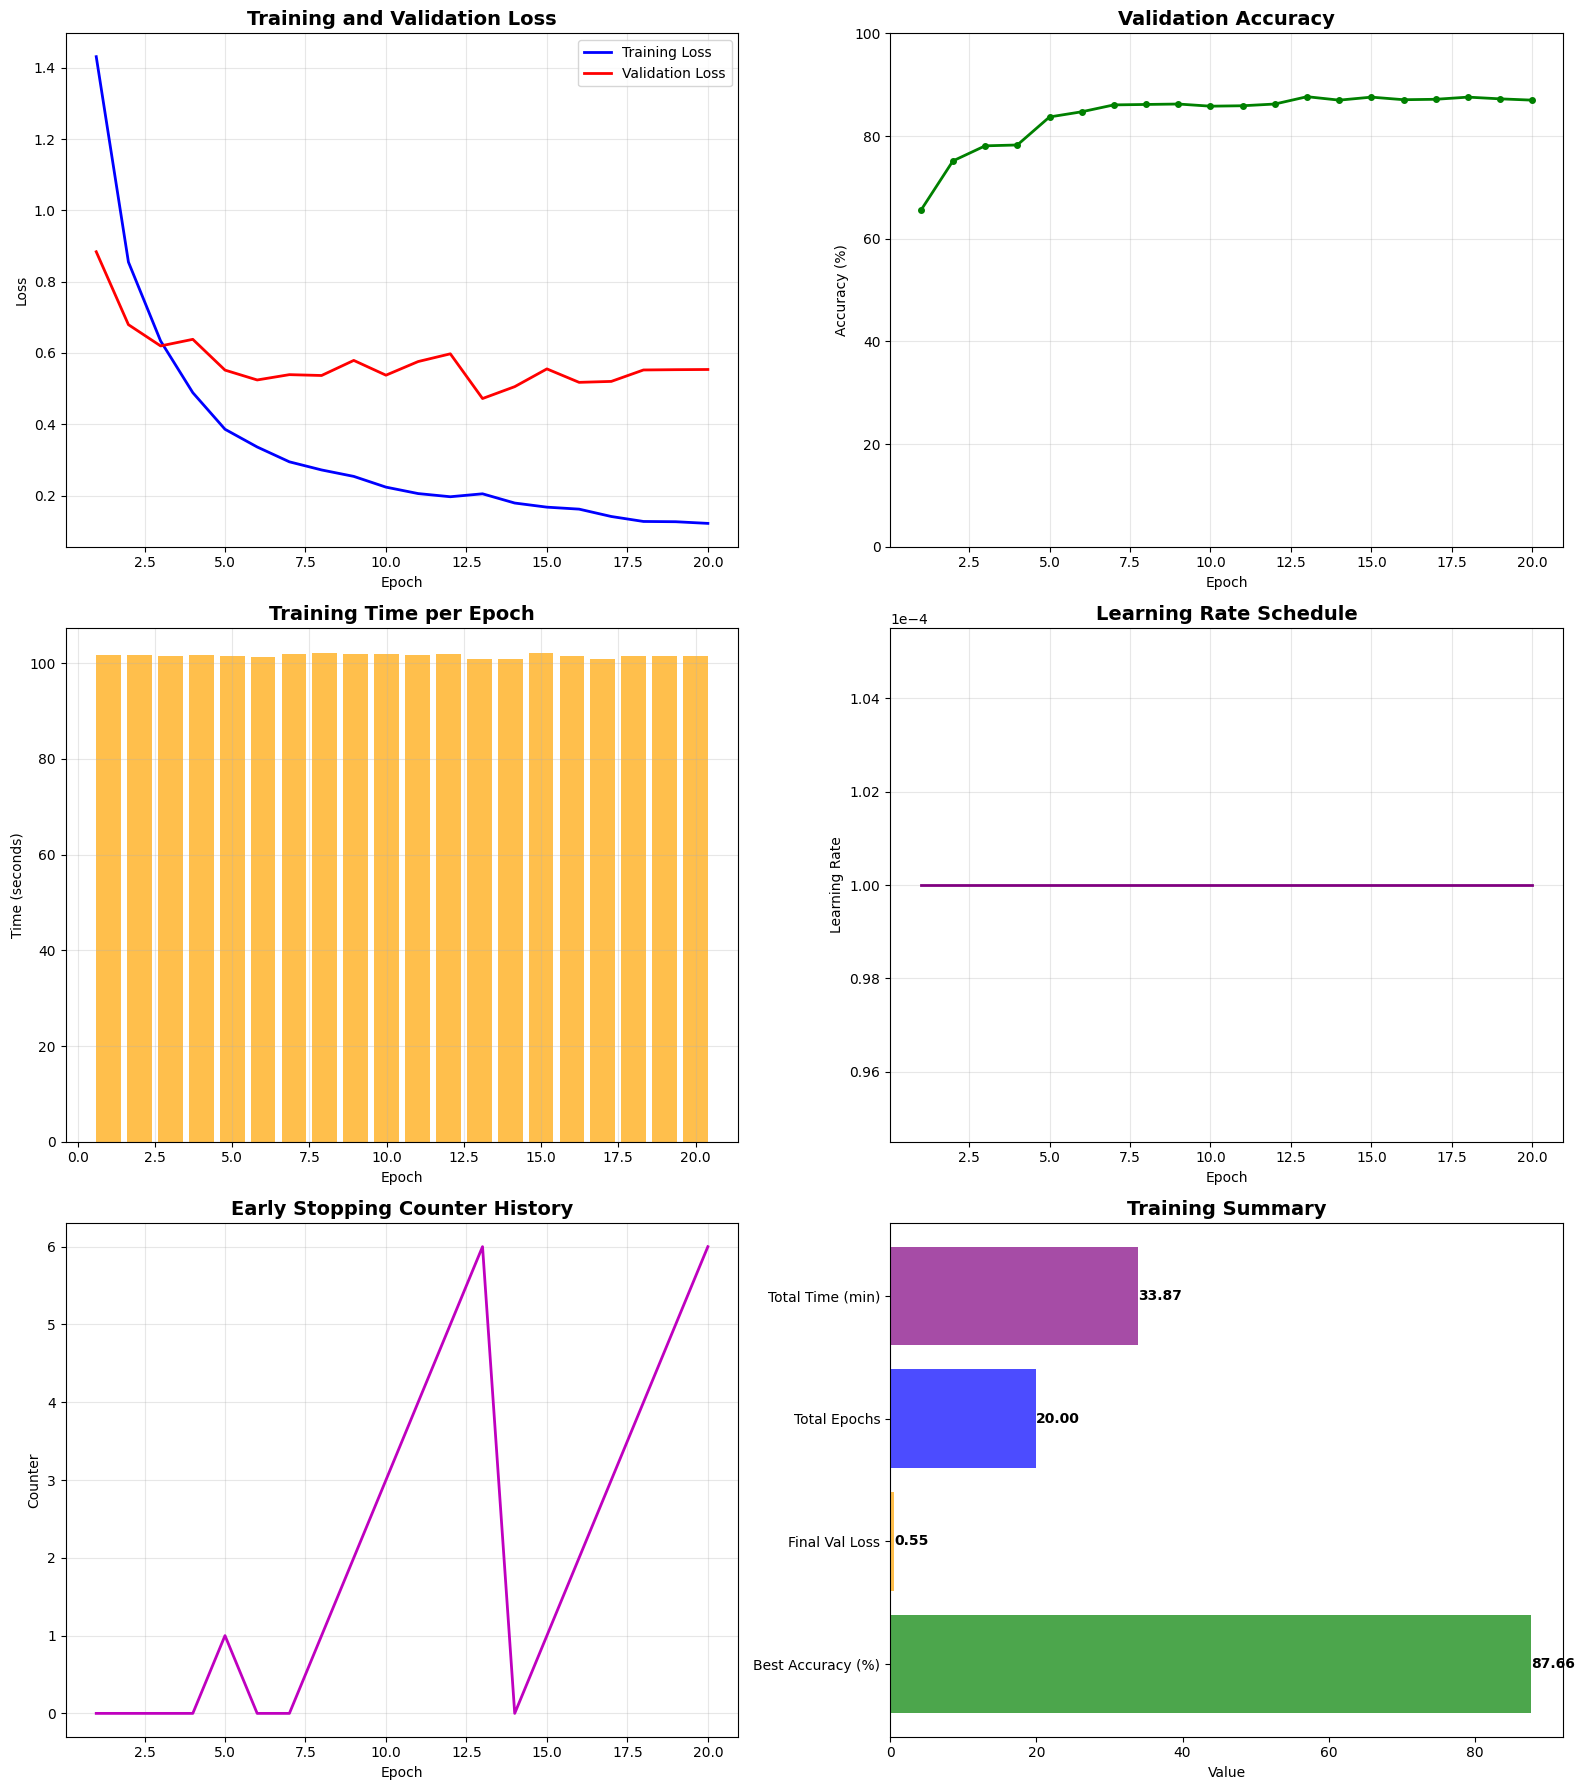


🛑 Early Stopping Analysis:
Early stopping triggered at epoch 20/25.
Epochs saved: 5
Time saved: ~8.5 minutes
Efficiency gain: 20.0%

📈 Detailed Training Statistics:
- Loss Reduction: 1.4315 → 0.1219 (91.5% improvement)
- Best Accuracy: 87.66% (Epoch 13)
- Total Training Time: 33.87 minutes
- Average Time per Epoch: 101.60s
- Fastest Epoch: 100.90s
- Slowest Epoch: 102.19s
- Early Stopping Counter History: [0, 0, 0, 0, 1, 0, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6]

📋 Training Metrics Table (Last 5 Epochs):
 Epoch  Train_Loss  Val_Loss  Val_Accuracy  Epoch_Time  Learning_Rate  ES_Counter
    16      0.1619    0.5176         87.07      101.59         0.0001           2
    17      0.1412    0.5203         87.15      100.91         0.0001           3
    18      0.1273    0.5524         87.57      101.45         0.0001           4
    19      0.1266    0.5532         87.24      101.52         0.0001           5
    20      0.1219    0.5537         86.99      101.46         0.0001       

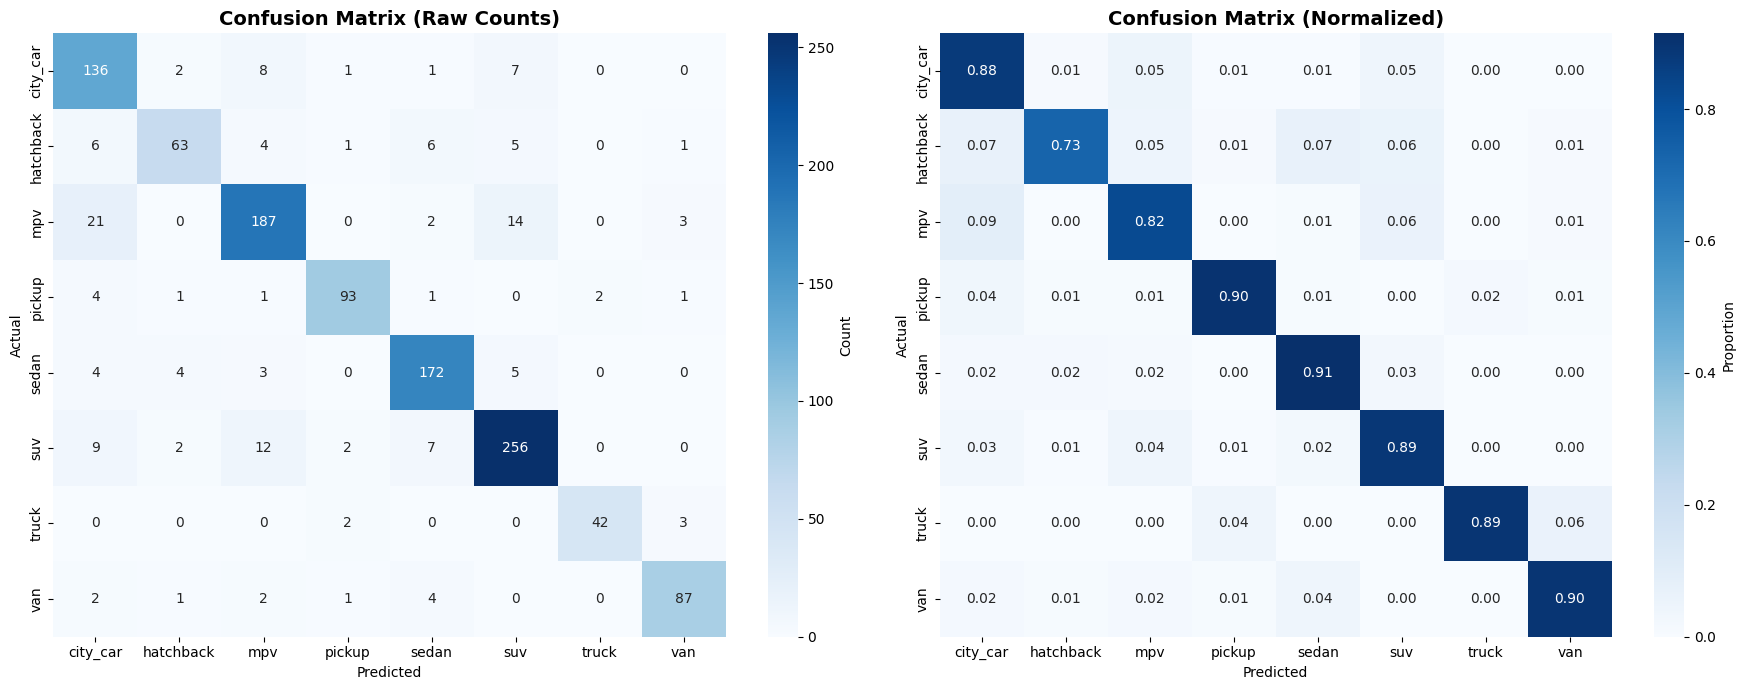


📊 Detailed Classification Report:
              precision    recall  f1-score   support

    city_car     0.7473    0.8774    0.8071       155
   hatchback     0.8630    0.7326    0.7925        86
         mpv     0.8618    0.8238    0.8423       227
      pickup     0.9300    0.9029    0.9163       103
       sedan     0.8912    0.9149    0.9029       188
         suv     0.8920    0.8889    0.8904       288
       truck     0.9545    0.8936    0.9231        47
         van     0.9158    0.8969    0.9062        97

    accuracy                         0.8699      1191
   macro avg     0.8819    0.8664    0.8726      1191
weighted avg     0.8729    0.8699    0.8701      1191


⚖️ Class Imbalance Impact Analysis:

📈 Class Group Performance:
Minority Classes (4): ['hatchback', 'pickup', 'truck', 'van']
Average Accuracy: 85.65%
Majority Classes (4): ['city_car', 'mpv', 'sedan', 'suv']
Average Accuracy: 87.62%
Performance Gap: 1.97% (Majority better)


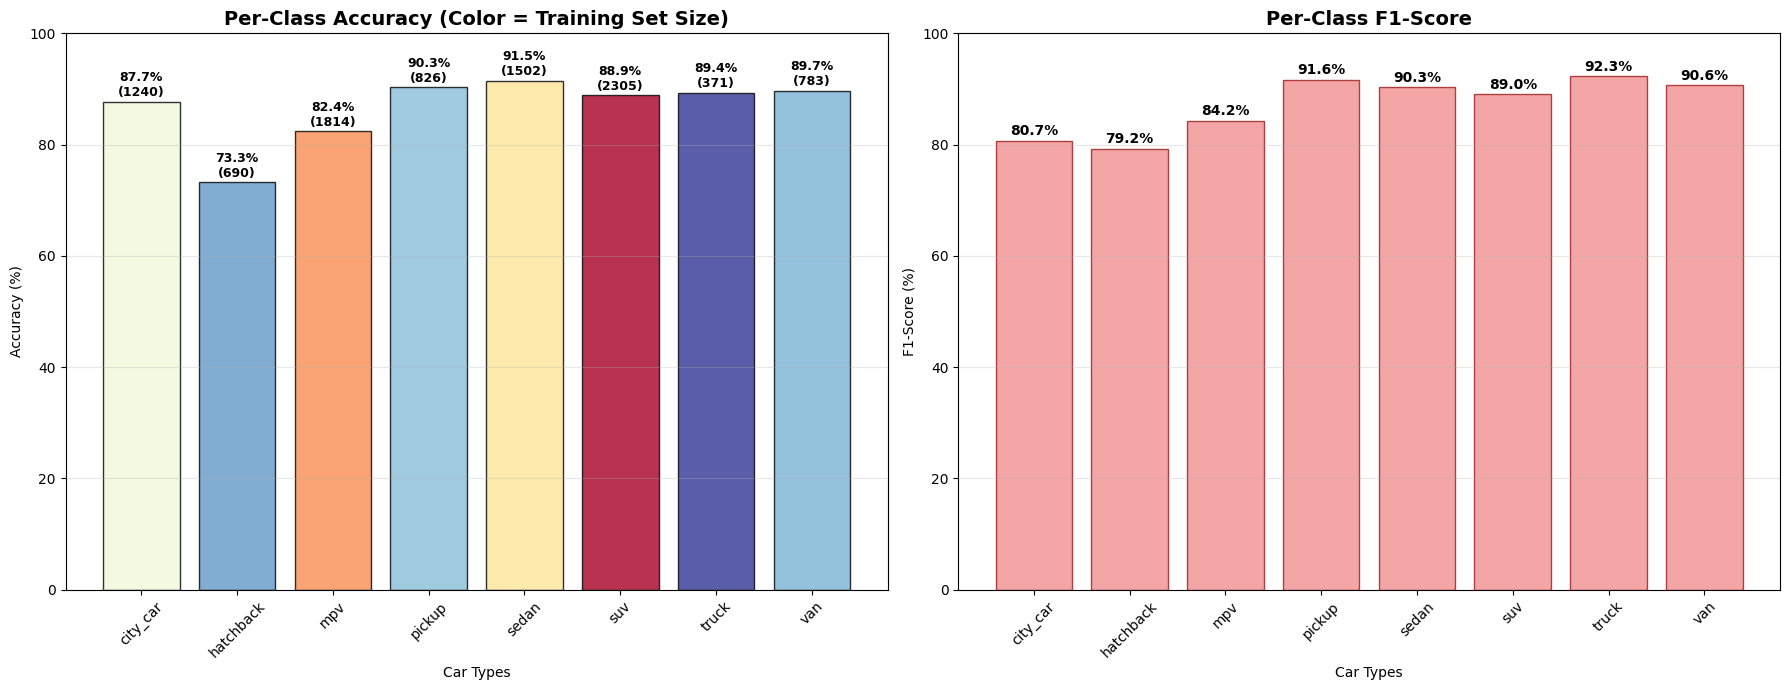


🛑 Early stopping summary saved to: models/classification/reports/early_stopping_summary_20250623_044249.json

💾 Training history saved to: models/classification/reports/training_history_20250623_044249.csv
📊 Class performance saved to: models/classification/reports/class_performance_20250623_044249.csv
🎯 Best model saved to: models/results/carvit_model_20250623_040556.pth
🏆 Best accuracy model saved to: models/results/carvit_model_20250623_040556_best_acc.pth

🎉 Training Analysis Complete!
🎯 Final Summary:
- Training completed in 20 epochs (planned: 25)
- Best validation accuracy: 87.66%
- Early stopping: Activated
- Total training time: 33.87 minutes
- Time saved by early stopping: 8.5 minutes
- Class imbalance: High (ratio: 6.21x)
- Model saved with best validation loss: 0.472221


In [5]:
report = TrainingReport(trainer, CONFIG, training_results)

# Generate the full report
report.full_report()